In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
from EDMtoolkit import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
filename = "baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

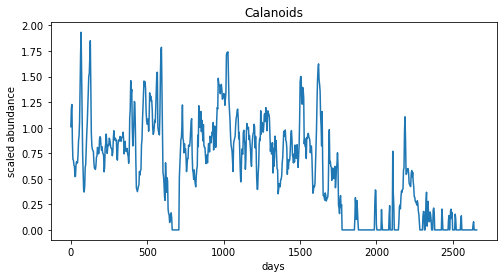

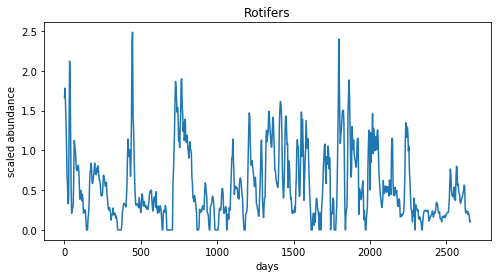

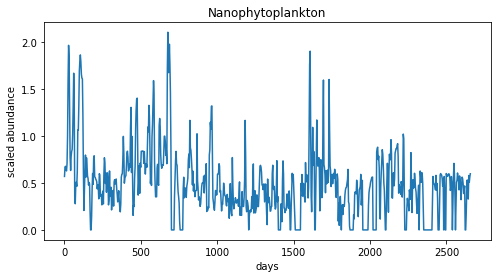

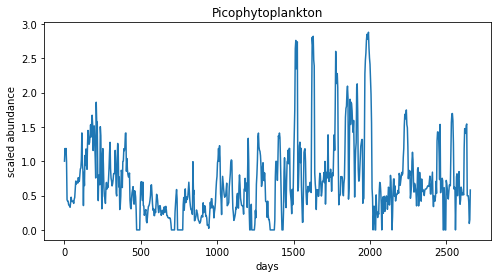

In [3]:
for i in range(4):
    fig, ax = plt.subplots(1,figsize=(8,4))
    ax.set_title(df.columns[i+1])
    ax.plot(table[:,0],table[:,i+1])
    ax.set_ylabel("scaled abundance")
    ax.set_xlabel("days")
    plt.show()
    
    # print(find_tau_autocorr(table[:,i]))

<IPython.core.display.Javascript object>


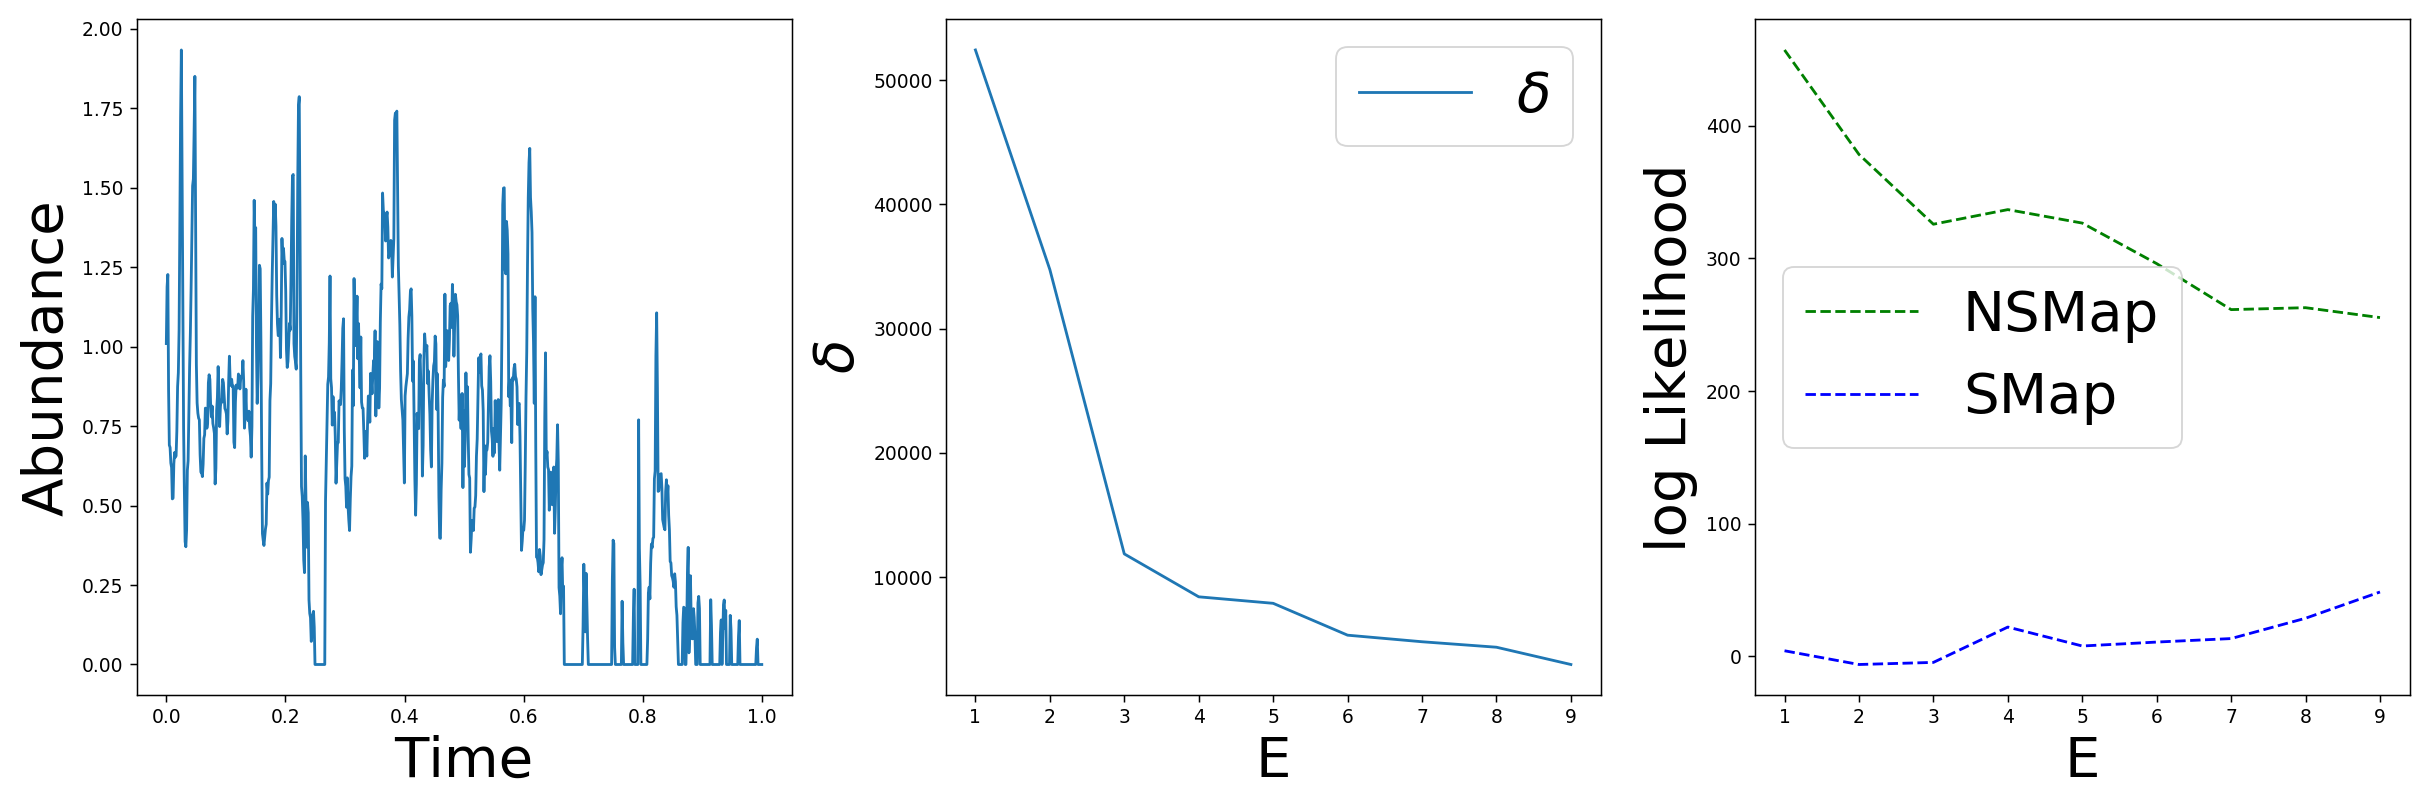

52435.27483938731

In [58]:
get_delta_agg(table[:,1], 8, tau=4, horizon=4)

# Tau Determination with forecast skill

In [5]:
def embed(x, h=0, E=2, tau=1):
    return delayEmbed(x, tau-h, E-1, embInterval=tau)

In [6]:
h = 0
E_max = 6
taus = np.arange(1,7)
r_sqrd_table = np.zeros((len(taus),4))

In [7]:
# for i, series in enumerate(table.T[1:]):
#     r_sqrds = [get_delta_agg(series, E_max-1, tau=tau, 
#                              horizon = tau - h,
#                              return_forecast_skill=True)[2] 
#                    for tau in taus]
#     r_sqrd_table[:,i] = r_sqrds
#     
# np.savetxt("baltic_sea_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")

In [58]:
# Check Autocorrelation

taus = np.arange(1,7)
autocorr_table = np.zeros((len(taus),4))

for i, series in enumerate(table.T[1:]):
    autocorr_table[:,i] = np.array([np.corrcoef(series[tau:],
                                                series[:-tau])[0,1]
                                  for tau in taus])

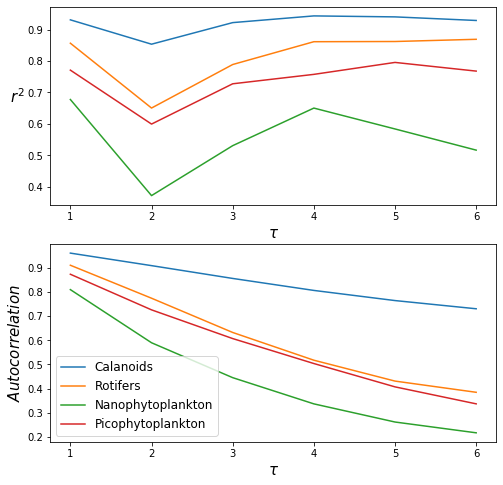

In [68]:
r_sqrd_table = np.loadtxt("baltic_sea_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(2,figsize=(8,8))
for i in range(4):
    ax[0].plot(taus, r_sqrd_table[:,i], label=df.columns[i+1])
    
for i in range(4):
    ax[1].plot(taus, autocorr_table[:,i], label=df.columns[i+1])

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)
# plt.savefig("../Figures/Empirical_embedding_parameter_choice/BalticSeaEmbeddingParameters.png", dpi = 300)
plt.savefig("../PDF_figures_tables/baltic_sea_multiwindow/BalticSeaEmbeddingParameters.pdf", format="pdf", bbox_inches="tight")

# Effect of Time Window on Baltic Sea Species

In [7]:
year_steps = 27
maxLen = table[:,0].shape[0]
lengths = np.arange(year_steps*4,maxLen+1,step=year_steps)

In [4]:
## This code computes the delta for each subseries, no longer needed

for i, species in zip([1,2,3,4], df.columns[1:].to_numpy()):
    ts = standardize(table[:,i])
    
    E = 5
    tau = 4
    h = 0

    # length, starting index, delta, theta, r_sqrd
    n_rows = 351
    results = np.zeros((n_rows, 5))
    tally = 0

    for length in lengths:
        for start in np.arange(0, maxLen - length+1, step=year_steps):

            ts_chunk = ts[start:length+start]
            # plotTS(ts_chunk)
            delta, theta, r_sqrd = get_delta_agg(ts_chunk, E-1, tau = tau, 
                                                 return_forecast_skill = True,
                                                 horizon = tau)
            results[tally] = np.array([length, start, delta, theta, r_sqrd])

            tally += 1
            print(tally)
    np.savetxt(f"{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
def makeHeatMapBaltic(results):
    nonstationarityHeatMap = np.zeros((29,29)) * np.nan
    for l, o, d, t, r in results:
        i_length = 27-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        # print(i_length, i_offset)
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

In [12]:
def makeFigureBaltic(nonstationarityHeatMap, ts, name, ax):
    scaling = lengths[-1] *3.35 / 365
    
    im = ax.imshow(np.log(nonstationarityHeatMap[:-2]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(31,step = 30 / scaling))
    ax.set_yticks(30-365*np.arange(1,8)/3.35/26) # DON'T TOUCH THIS LINE
    ax.set_xticklabels([])
    ax.set_yticklabels(np.arange(1,8))
    ax.set_ylim(27,-1)
    ax.set_xlim(-1.3,32)
    
    ax.set_ylabel("Time series length (years)",fontsize=15)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(table[:,0]/365, ts,c="dodgerblue")
    axTS.set_ylabel(name,fontsize=12)
    axTS.set_xlabel("Start year",fontsize=15)
    axTS.set_yticks([])

    # plt.savefig(f"../Figures/baltic_sea_multiwindow_analysis/{name}_multiwindow.png", dpi=300)
    plt.savefig(f"../PDF_figures_tables/baltic_sea_multiwindow/{name}_multiwindow.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [10]:
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 
# ListedColormap(np.array([dodgerblue_rgba, orange_rgba]))

0.92332


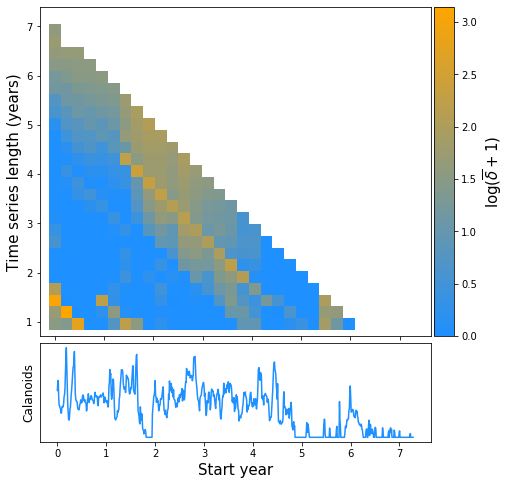

0.83295


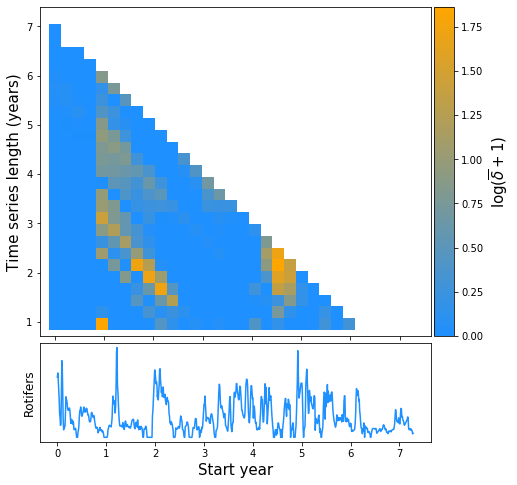

0.64945


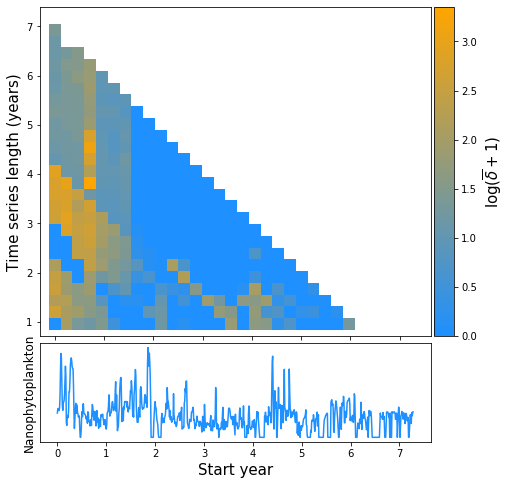

0.76455


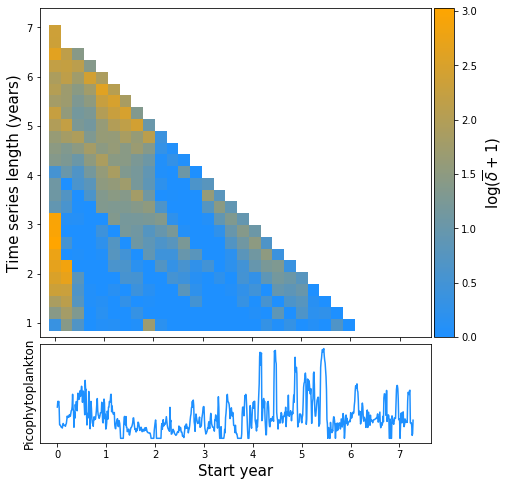

In [13]:
#for index in range(4):
indices = [0,1,2,3]
year_steps = 27

for index in indices:
    figb, axb = plt.subplots(1, figsize=(8,8))
    
    species_list = ["Calanoids","Rotifers","Nanophytoplankton",
                    "Picophytoplankton"]
    results = np.loadtxt(f"baltic_sea_original/{species_list[index]}_time_window.csv",
                         delimiter=",")
    lengths = np.unique(results[:,0])
    
    print(results[-1,4])
    
    ts = standardize(table[:,index+1])
    nonstationarityHeatMap = makeHeatMapBaltic(results)
    makeFigureBaltic(nonstationarityHeatMap, ts, species_list[index], axb)

In [326]:
results[:,[True, False, True, False, True]]
np.set_printoptions(suppress=True)
results[-1,[True, False, True, False, True]]

array([780.     ,   4.05881,   0.92332])

<IPython.core.display.Javascript object>


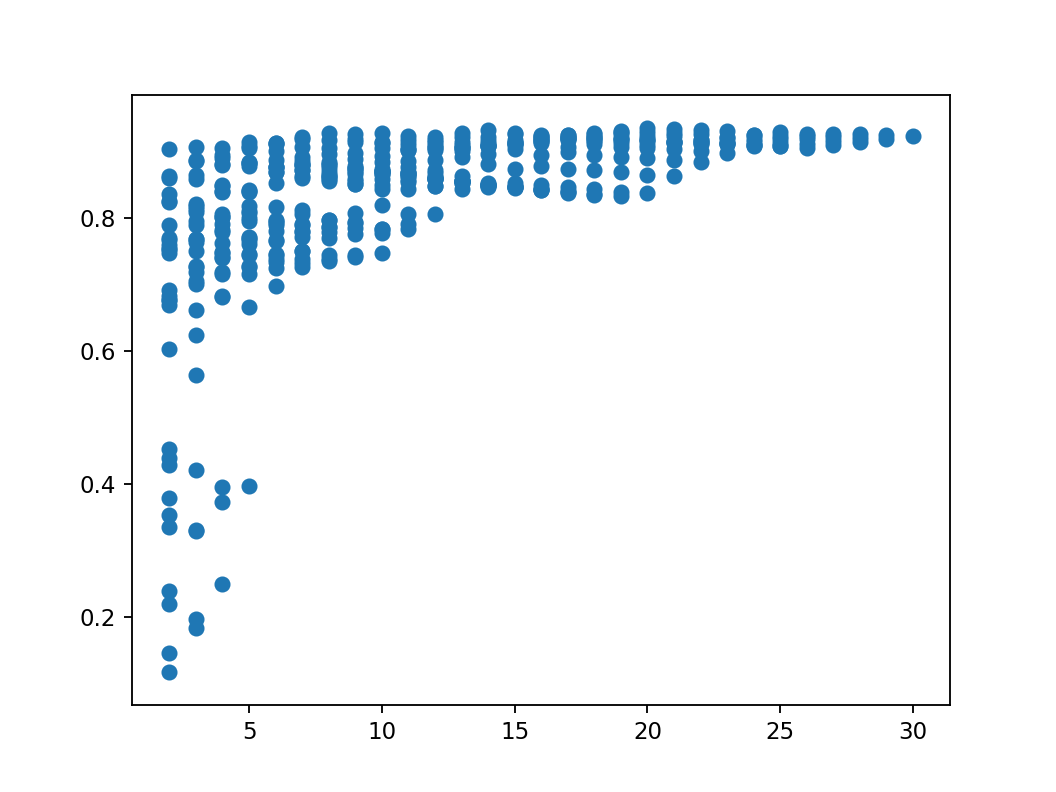

In [316]:
figr2 = plt.figure()
plt.scatter(results[:,0]/year_steps,results[:,-1])